## This is my jupyter notebook for sentiment analysis task ##

Our sentiment can be either 1 (positive) or 0 (negative) <br>

In this notebook, I am trying to do <br>

1. Bidirectional-LSTM <br>
2. Logistic Regression with TF-idf vectorizer<br>
3. Logistic Regression with CountVectorizer<br>

<h3> SUMMARY </h3>

<p> In bidirectional LSTM, we do a text preprocessing by "lower" all the text and tokenize by using "text_to_word_sequence" provided bhy Keras. <br>
    By default, this function automatically does 3 things:</p><br>

        > Splits words by space (split=” “).
        > Filters out punctuation (filters=’!”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n’).<br>
        > Converts text to lowercase (lower=True).<br>
    
    Finally, vectorize a text by using tokenizer API by Keras 
    
<p> For Logistic regression, it appears that TF-idf performs better than Countvectorizer. </p>
    <p> CountVectorizer is used with two parameters — </p>

    > min_df : defines the minimum frequency of a word for it to be counted as a feature (in my case, I set it to 2)
    > ngram_range : The ngram_range parameter is a tuple. It defines the minimum and maximum length of sequence of tokens considered. In this case, this length is 2. So, this will find sequence of 2 tokens like — ‘but the’, ‘wise man’ etc. (in my case, I set it to (1,1))
    
    
<h3> RESULTS </h3>

| Model                   | Dev set | Validation set |
|-------------------------|---------|----------------|
| Bidirectional-LSTM      | 80.75   | 81.24          |
| LR with TF-idf          | 80.46   | 80.81          |
| LR with countvectorizer | 78.25   | 79             |

ROC curve of both LR and report on Bi-LSTM are provided below.

## Bidirectional LSTM ##

In [149]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Bidirectional
import pandas as pd
import numpy as np


In [150]:
train = pd.read_csv('http://www.sansarn.com/its489/twitter_sentiment_train.csv', sep=',')

In [151]:
train['Positivity'] = np.where(train['polarity'] == 4, 1, 0)


In [152]:
train['Positivity'].value_counts()

1    128071
0    127929
Name: Positivity, dtype: int64

In [153]:
train['text'].str.len().max()

326

In [154]:
train['text'].str.len().mean()

74.0726328125

In [155]:
train['text'] = train['text'].apply(lambda x: x.lower())

In [156]:
X = train.text
y = train.Positivity

In [157]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(list(X))


In [158]:
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen = 326)

In [159]:
from sklearn.model_selection import train_test_split
Y=[]
for val in y:
    if(val == 0):
        Y.append([1,0])
    else:
        Y.append([0,1])
Y = np.array(Y)
    
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 42)

In [160]:
from keras.layers import Dense, Embedding,LSTM
from keras.models import Sequential

We have 2 hidden layer. The more we have, the more our neural network will perceive a complicated sentence.

In [161]:
max_features = 10000
model = Sequential()

# Input / Embdedding
model.add(Embedding(max_features,100,mask_zero=True))
model.add(Bidirectional(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True)))
model.add(Bidirectional(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False)))

# Output layer
model.add(Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         84480     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 1,125,826
Trainable params: 1,125,826
Non-trainable params: 0
_________________________________________________________________


In [162]:
epochs = 2
batch_size = 32

In [163]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

filepath="BiLSTM_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1,callbacks = [checkpoint])

Train on 179200 samples, validate on 76800 samples
Epoch 1/2
179200/179200 [==============================] - 7491s 42ms/step - loss: 0.4676 - acc: 0.7780 - val_loss: 0.4306 - val_acc: 0.7977

Epoch 00001: val_acc improved from -inf to 0.79773, saving model to BiLSTM_best_weights.01-0.7977.hdf5
Epoch 2/2
179200/179200 [==============================] - 7684s 43ms/step - loss: 0.4104 - acc: 0.8124 - val_loss: 0.4237 - val_acc: 0.8037

Epoch 00002: val_acc improved from 0.79773 to 0.80371, saving model to BiLSTM_best_weights.02-0.8037.hdf5


## Handle Dev set ##

In [164]:
dev = pd.read_csv('http://www.sansarn.com/its489/twitter_sentiment_dev.csv', sep=',')

In [165]:
dev['Positivity'] = np.where(dev['polarity'] == 4, 1, 0)
dev.head()

,polarity,tweet ID,date,query,username,text,Positivity
0,0,2059754550,Sat Jun 06 17:34:13 PDT 2009,NO_QUERY,patsycline27,"@sc430girl no, not yet lol",0
1,4,2010892965,Tue Jun 02 18:08:26 PDT 2009,NO_QUERY,crookrooker,break a leg and good luck to everyone at tomor...,1
2,4,1958136417,Fri May 29 02:47:07 PDT 2009,NO_QUERY,harrieverveer,@DerBart right now they have &quot;Lancï¿½me M...,1
3,0,2250446267,Sat Jun 20 00:32:57 PDT 2009,NO_QUERY,Yidhen,THERE'S no flames anymore! How can there be no...,0
4,4,2176325770,Mon Jun 15 03:33:51 PDT 2009,NO_QUERY,VeryScott,There's nothing like driving to work with the ...,1


In [166]:
dev['text'] = dev['text'].apply(lambda x: x.lower())

In [167]:
dev_X = dev['text']

In [168]:
dev_X = tokenizer.texts_to_sequences(dev_X)
dev_X = pad_sequences(dev_X, maxlen = 326)

In [169]:
dev['Sentiment'] = model.predict_classes(dev_X, batch_size=batch_size, verbose=1)
dev.to_csv('lstm.csv', index=False)

64000/64000 [==============================] - 570s 9ms/step


In [179]:
from keras.models import load_model
loaded_CNN_model = load_model('BiLSTM_best_weights.02-0.8037.hdf5')
loaded_CNN_model.evaluate(x= X_test, y= y_test, verbose = 1)

76800/76800 [==============================] - 659s 9ms/step


[0.4236927524457375, 0.8037109375]

In [196]:
yhat_cnn = loaded_CNN_model.predict(X_test)

#จะเอาไปแสดง roc_curve แต่ทำไม่ได้  คิดว่ามีปัญหาที่ Y ที่เป็น array สองมิติ

## Confusion matrix of Bidirectional- LSTM

In [220]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(dev['Positivity'], dev['Sentiment'])
cm

array([[26089,  5643],
       [ 6653, 25615]], dtype=int64)

## Classification report of Bidirectional- LSTM

In [222]:
from sklearn.metrics import classification_report
print(classification_report(dev['Positivity'], dev['Sentiment']))

             precision    recall  f1-score   support

          0       0.80      0.82      0.81     31732
          1       0.82      0.79      0.81     32268

avg / total       0.81      0.81      0.81     64000



In [170]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(dev['Positivity'], dev['Sentiment'])

## Accuracy of Birectional LSTM with the Dev set

In [181]:
acc *100

80.7875

## Logistic Regression with TF-idf

In [172]:
train2 = pd.read_csv('http://www.sansarn.com/its489/twitter_sentiment_train.csv', sep=',')

train2['Positivity'] = np.where(train2['polarity'] == 4, 1, 0)

X2 = train2.text
y2 = train2.Positivity

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2 ,random_state = 7)

In [173]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.pipeline import Pipeline


In [174]:
def accuracy_summary(name,pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(name," accuracy score: {0:.2f}%".format(accuracy*100))
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))
    
    return accuracy

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

models = []
models.append(('LR', LogisticRegression()))

# evaluate each model in turn
results = []
names = []
for name, modelz in models:
  tfidf = TfidfVectorizer()
  checker_pipeline = Pipeline([
            ('vectorizer', tfidf),
            ('classifier', modelz)
        ])
   
  accuracy2 = accuracy_summary(name,checker_pipeline, X_train2, y_train2, X_test2, y_test2)
   
  print()

LR  accuracy score: 79.42%
             precision    recall  f1-score   support

   negative       0.79      0.79      0.79     25486
   positive       0.79      0.80      0.80     25714

avg / total       0.79      0.79      0.79     51200




In [186]:
# n_features = [100,500,1000,5000,10000,20000,30000]
n_features = [90000, 150000, 170000, 201000]
n_max = 0
accu_max = 0
for n in n_features:
  lr = LogisticRegression(C=1)
  tfidf = TfidfVectorizer(max_features=n,ngram_range=(1, 3), max_df=0.5)
  checker_pipeline = Pipeline([
          ('vectorizer', tfidf),
          ('classifier', lr)
      ])

  accuracy = accuracy_summary('number_features='+str(n),checker_pipeline, X_train2, y_train2, X_test2, y_test2)
  if accu_max < accuracy:
    accu_max = accuracy
    n_max = n
print("Max accuracy:", accu_max)
print("Max #features:",n_max)

number_features=90000  accuracy score: 80.75%
             precision    recall  f1-score   support

   negative       0.81      0.80      0.81     25486
   positive       0.81      0.81      0.81     25714

avg / total       0.81      0.81      0.81     51200

number_features=150000  accuracy score: 80.81%
             precision    recall  f1-score   support

   negative       0.81      0.80      0.81     25486
   positive       0.81      0.81      0.81     25714

avg / total       0.81      0.81      0.81     51200

number_features=170000  accuracy score: 80.78%
             precision    recall  f1-score   support

   negative       0.81      0.81      0.81     25486
   positive       0.81      0.81      0.81     25714

avg / total       0.81      0.81      0.81     51200

number_features=201000  accuracy score: 80.77%
             precision    recall  f1-score   support

   negative       0.81      0.81      0.81     25486
   positive       0.81      0.81      0.81     25714

avg / t

## Handle dev set 2 for LR 

In [187]:
dev2 = pd.read_csv('http://www.sansarn.com/its489/twitter_sentiment_dev.csv', sep=',')

In [188]:
dev2['Positivity'] = np.where(dev2['polarity'] == 4, 1, 0)

## Accuracy of Logistic Regression with TFidf

In [189]:
n = 150000
lr = LogisticRegression(C=1)
tfidf = TfidfVectorizer(max_features=n,ngram_range=(1, 3),max_df=0.5)
checker_pipeline = Pipeline([
        ('vectorizer', tfidf),
        ('classifier', lr)
    ])

accuracy = accuracy_summary('number_features='+str(n),checker_pipeline, X_train2, y_train2, dev2.text, dev2.Positivity)

number_features=150000  accuracy score: 80.46%
             precision    recall  f1-score   support

   negative       0.81      0.80      0.80     31732
   positive       0.80      0.81      0.81     32268

avg / total       0.80      0.80      0.80     64000



In [191]:
tvec = TfidfVectorizer(max_features=150000,ngram_range=(1, 3))
tvec.fit(X_train2)
x_train2_tfidf = tvec.transform(X_train2)
x_test2_tfidf = tvec.transform(X_test2)
lr_with_tfidf = LogisticRegression(C=1)
lr_with_tfidf.fit(x_train2_tfidf,y_train2)
yhat_lr = lr_with_tfidf.predict_proba(x_test2_tfidf)
lr_with_tfidf.score(x_test2_tfidf,y_test2)

0.80814453125

## Logistic Regression with countvectorizer

In [223]:
train3 = pd.read_csv('http://www.sansarn.com/its489/twitter_sentiment_train.csv', sep=',')
train3['Positivity'] = np.where(train3['polarity'] == 4, 1, 0)
X3 = train3.text
y3 = train3.Positivity

from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,test_size = 0.2, random_state = 1)

In [224]:
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(min_df=2, ngram_range=(1, 1))
X_train3 = cvect.fit(X_train3).transform(X_train3)
X_test3 = cvect.transform(X_test3)

print("Vocabulary size: {}".format(len(cvect.vocabulary_)))
print("X_train:\n{}".format(repr(X_train3)))
print("X_test: \n{}".format(repr(X_test3)))

feature_names = cvect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Vocabulary size: 45743
X_train:
<204800x45743 sparse matrix of type '<class 'numpy.int64'>'
	with 2313195 stored elements in Compressed Sparse Row format>
X_test: 
<51200x45743 sparse matrix of type '<class 'numpy.int64'>'
	with 567651 stored elements in Compressed Sparse Row format>
Number of features: 45743


Implement GridSearch to find the best parameter from the given params with 5-folds cross validation

In [226]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1,2, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train3, y_train3)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.79
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Make a prediction with the best parameter

In [237]:
lr2 = grid.best_estimator_
lr2.fit(X_train3, y_train3)
lr2.predict(X_test3)
yhat_lr2 = lr2.predict_proba(X_test3)
print("Score: {:.2f}".format(lr2.score(X_test3, y_test3)))

Score: 0.79


In [231]:
dev3 = pd.read_csv('http://www.sansarn.com/its489/twitter_sentiment_dev.csv', sep=',')
dev3['Positivity'] = np.where(dev3['polarity'] == 4, 1, 0)

dev_X3 = dev3['text']

cvect2 = CountVectorizer(min_df=2, ngram_range=(1, 1))
dev_train3 = cvect2.fit(dev_X3).transform(dev_X3)




In [236]:
# พยายามจะ run กับ dev แล้ว แต่มันติดปัญหาไรวะ

<64000x19587 sparse matrix of type '<class 'numpy.int64'>'
	with 706999 stored elements in Compressed Sparse Row format>

## ROC curve comparison with 2 Logistic regression

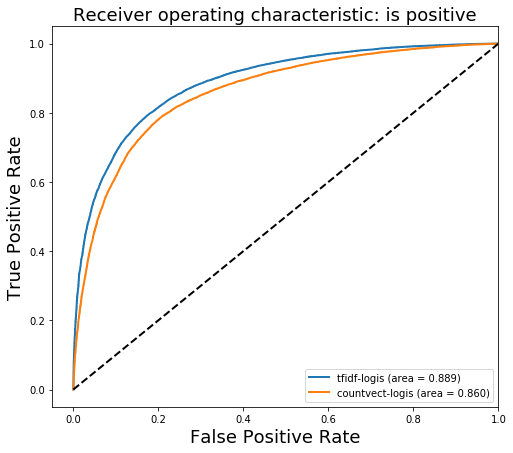

In [239]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, threshold = roc_curve(y_test2, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test3, yhat_lr2[:,1])
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logis (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='countvect-logis (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()